In [1]:
# ============================================
# Customer Satisfaction Prediction (End-to-End)
# Beginner → Advanced: Models + ROC + Explainability
# ============================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.inspection import permutation_importance

warnings.filterwarnings("ignore")

# -----------------------------
# 0) Load Data
# -----------------------------
df = pd.read_csv("/content/customer_support_tickets.csv")
print("Shape:", df.shape)

TARGET_COL = "Customer Satisfaction Rating"
df = df.dropna(subset=[TARGET_COL])

# -----------------------------
# 1) Detect Features
# -----------------------------
obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

text_cols = [c for c in obj_cols if "subject" in c.lower() or "description" in c.lower()]
cat_cols = [c for c in obj_cols if c not in text_cols and c != TARGET_COL]
num_cols = [c for c in num_cols if c != TARGET_COL]

print("Text cols:", text_cols)
print("Cat cols:", cat_cols)
print("Num cols:", num_cols)

# -----------------------------
# 2) Split Data
# -----------------------------
y = df[TARGET_COL].astype(int) - 1   # shift from {1–5} → {0–4}
X = df.drop(columns=[TARGET_COL])
use_cols = num_cols + cat_cols + text_cols
X = X[use_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------
# 3) Preprocessing
# -----------------------------
numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

transformers = []
if num_cols: transformers.append(("num", numeric_tf, num_cols))
if cat_cols: transformers.append(("cat", categorical_tf, cat_cols))
for col in text_cols:
    transformers.append((f"tfidf_{col}", TfidfVectorizer(max_features=3000), col))

preprocessor = ColumnTransformer(transformers=transformers)



Shape: (8469, 17)
Text cols: ['Ticket Subject', 'Ticket Description']
Cat cols: ['Customer Name', 'Customer Email', 'Customer Gender', 'Product Purchased', 'Date of Purchase', 'Ticket Type', 'Ticket Status', 'Resolution', 'Ticket Priority', 'Ticket Channel', 'First Response Time', 'Time to Resolution']
Num cols: ['Ticket ID', 'Customer Age']


In [2]:
  # -----------------------------
  # 4) Define Models
  # -----------------------------
  models = {
      "Dummy": DummyClassifier(strategy="most_frequent"),
      "LogisticRegression": LogisticRegression(max_iter=200, class_weight="balanced"),
      "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced")
  }

  # Optional XGBoost
  try:
      from xgboost import XGBClassifier
      models["XGBoost"] = XGBClassifier(
          objective="multi:softprob", num_class=5, eval_metric="mlogloss",
          random_state=42, n_estimators=300
      )
  except:
      print("⚠️ XGBoost not available.")

  # -----------------------------
  # 5) Train & Compare
  # -----------------------------
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  results = {}

  for name, clf in models.items():
      pipe = Pipeline([("prep", preprocessor), ("clf", clf)])
      scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
      results[name] = scores.mean()
      print(f"{name} CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

  # Pick best model
  best_name = max(results, key=results.get)
  print("\n✅ Best model:", best_name)

  best_pipe = Pipeline([("prep", preprocessor), ("clf", models[best_name])])
  best_pipe.fit(X_train, y_train)




Dummy CV Accuracy: 0.2095 ± 0.0009
LogisticRegression CV Accuracy: 0.2140 ± 0.0310
RandomForest CV Accuracy: 0.2113 ± 0.0172
XGBoost CV Accuracy: 0.1968 ± 0.0105

✅ Best model: LogisticRegression


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Ticket ID',
                                                   'Customer Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Customer Name',
                                                   'Customer Email',
                                                   'Customer...
                                                   'Date of Purchase',
                                                   'Ticket Type',
                                                   'Ticket Status',
                                                   'Resolution',
                                                   'Ticket Priority',
                                                   'Ticket Channel',
                                                   'First Response Time',
                                                   'Time to Resolution']),
                                                 ('tfidf_Ticket Subject',
                                                  TfidfVectorizer(max_features=3000),
                                                  'Ticket Subject'),
                                                 ('tfidf_Ticket Description',
                                                  TfidfVectorizer(max_features=3000),
                                                  'Ticket Description')])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=200))])


=== Test Set Evaluation ===
Accuracy: 0.2003610108303249

Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.23      0.23       111
           1       0.18      0.21      0.20       110
           2       0.23      0.26      0.24       116
           3       0.20      0.17      0.18       108
           4       0.16      0.13      0.14       109

    accuracy                           0.20       554
   macro avg       0.20      0.20      0.20       554
weighted avg       0.20      0.20      0.20       554



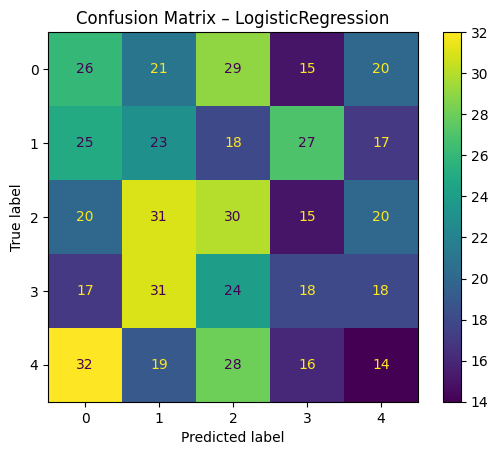

In [3]:
# -----------------------------
# 6) Evaluation on Test Set
# -----------------------------
y_pred = best_pipe.predict(X_test)
print("\n=== Test Set Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion Matrix – {best_name}")
plt.show()



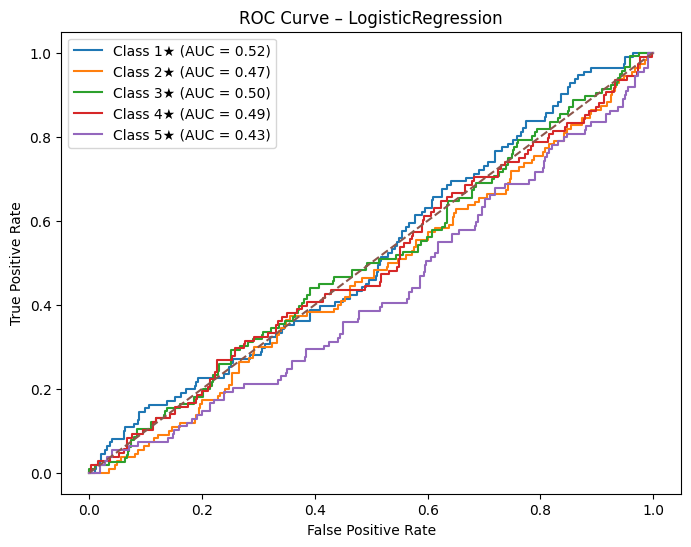

In [4]:
# -----------------------------
# 7) ROC Curve (One-vs-Rest)
# -----------------------------
classes = sorted(y.unique())
y_test_bin = label_binarize(y_test, classes=classes)

# transform X for probabilities
X_test_transformed = best_pipe.named_steps["prep"].transform(X_test)
ovr = OneVsRestClassifier(best_pipe.named_steps["clf"])
ovr.fit(best_pipe.named_steps["prep"].transform(X_train), y_train)
y_score = ovr.predict_proba(X_test_transformed)

plt.figure(figsize=(8,6))
for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {c+1}★ (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {best_name}")
plt.legend()
plt.show()



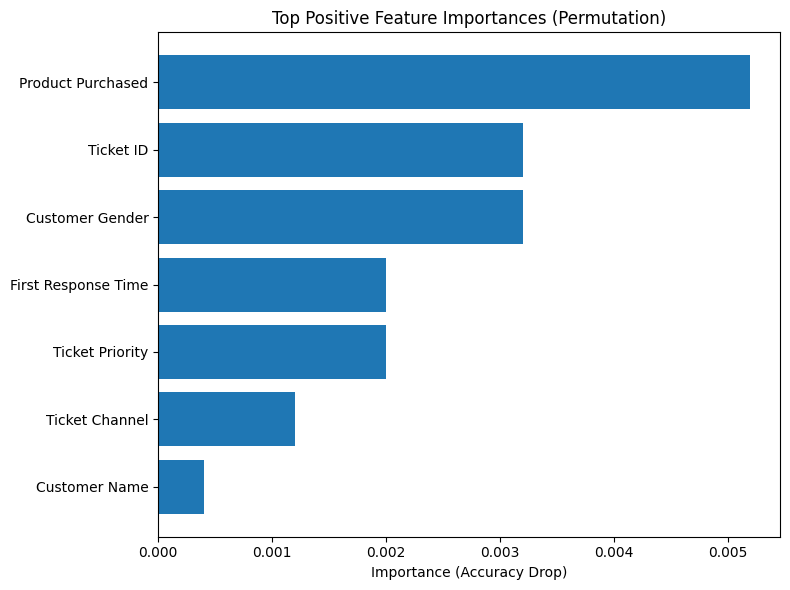


Top features by permutation importance:
                Feature  Importance
5     Product Purchased      0.0052
0             Ticket ID      0.0032
4       Customer Gender      0.0032
12  First Response Time      0.0020
10      Ticket Priority      0.0020
11       Ticket Channel      0.0012
2         Customer Name      0.0004

 Saved final model pipeline to pipeline.pkl


In [5]:
# -----------------------------
# 8) Permutation Importance
# -----------------------------
try:
    sample_idx = np.random.RandomState(42).choice(len(X_test), size=min(500, len(X_test)), replace=False)
    X_sample = X_test.iloc[sample_idx]
    y_sample = y_test.iloc[sample_idx]

    perm = permutation_importance(
        best_pipe, X_sample, y_sample,
        scoring="accuracy", n_repeats=5, random_state=42, n_jobs=-1
    )
    importances = perm.importances_mean
    feature_names = use_cols

    # Build DataFrame for clarity
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    })

    # ✅ Filter: keep only positive importances
    importance_df = importance_df[importance_df["Importance"] > 0]

    # Sort descending
    importance_df = importance_df.sort_values(by="Importance", ascending=False).head(15)

    # Plot
    plt.figure(figsize=(8,6))
    plt.barh(importance_df["Feature"], importance_df["Importance"])
    plt.gca().invert_yaxis()
    plt.title("Top Positive Feature Importances (Permutation)")
    plt.xlabel("Importance (Accuracy Drop)")
    plt.tight_layout()
    plt.show()

    # Print table for reference
    print("\nTop features by permutation importance:")
    print(importance_df)

except Exception as e:
    print("Permutation importance skipped:", e)


# -----------------------------
# 9) Save Final Model
# -----------------------------
with open("pipeline.pkl", "wb") as f:
    pickle.dump(best_pipe, f)

print("\n Saved final model pipeline to pipeline.pkl")